In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import shap
import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv("/content/drive/MyDrive/Delivery_On_Time_Prediction_ML_Project/Dataset/Train.csv")
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [12]:
df.shape

(10999, 12)

In [13]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


,0
ID,0
Warehouse_block,0
Mode_of_Shipment,0
Customer_care_calls,0
Customer_rating,0
Cost_of_the_Product,0
Prior_purchases,0
Product_importance,0
Gender,0
Discount_offered,0


*EDA*

<Axes: >

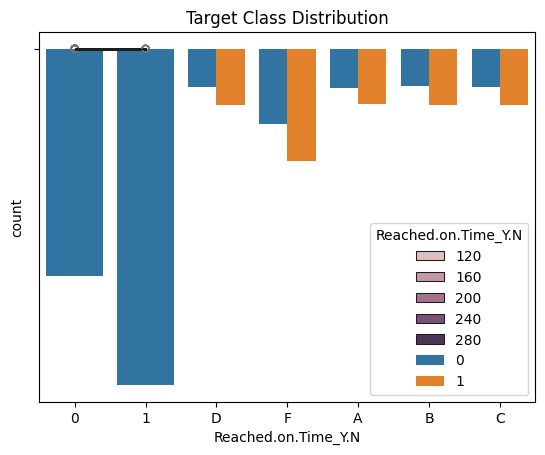

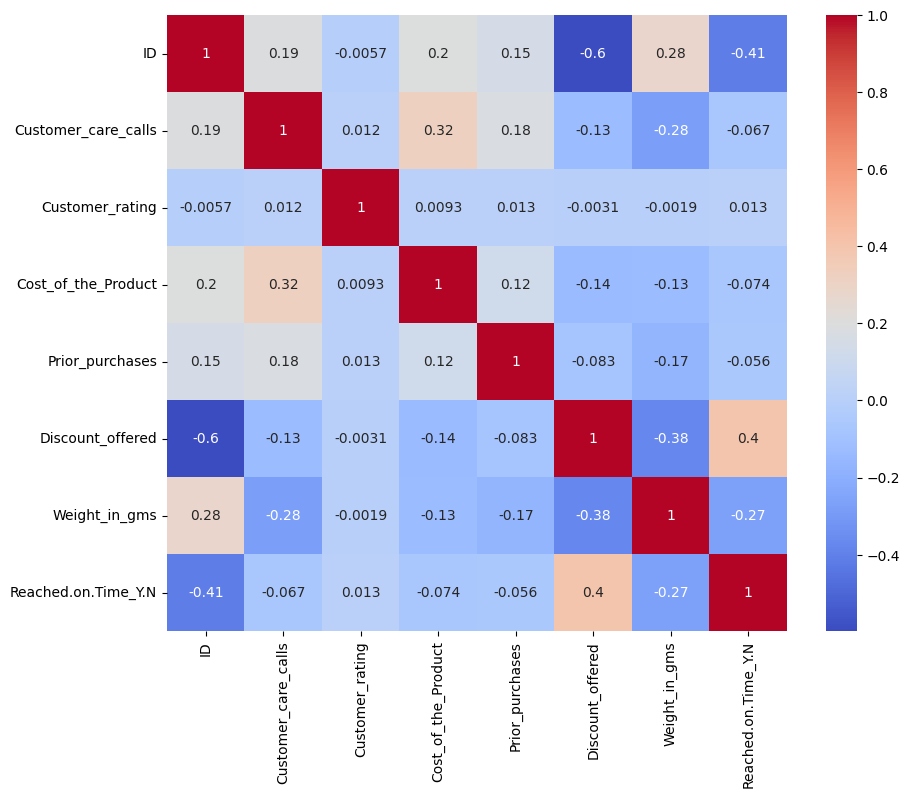

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Target distribution
sns.countplot(data=df, x='Reached.on.Time_Y.N')
plt.title('Target Class Distribution')

# Feature vs Target
sns.boxenplot(data=df, x='Reached.on.Time_Y.N', hue = 'Cost_of_the_Product')
sns.countplot(data=df, x='Warehouse_block', hue = 'Reached.on.Time_Y.N')

#Correlation heatmap
plt.figure(figsize=(10,8))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot = True, cmap='coolwarm')

In [16]:
#Data Cleaning and Encoding
#drop irrelevant columns
df.drop(['ID'], axis=1, inplace=True)

#Encoding categoricals
cat_features = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
le = LabelEncoder()
for col in cat_features:
    df[col] = le.fit_transform(df[col])

In [17]:
#Feature Engineering
df['cost_rating_ratio'] = df['Cost_of_the_Product']/df['Customer_rating']
df['volume_discount'] = df['Weight_in_gms']*df['Discount_offered']

In [22]:
# Clustering
from sklearn.cluster import KMeans
cluster_model = KMeans(n_clusters=3, random_state=0)
df['cluster'] = cluster_model.fit_predict(df[['Cost_of_the_Product', 'Weight_in_gms']])

In [24]:
# Train/Test split
X = df.drop('Reached.on.Time_Y.N', axis=1)
y = df['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [25]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

for name, model in models.items():
  scores = cross_val_score(model, X_train, y_train, cv=5, scoring ='accuracy')
  print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f}")

RandomForest Cross-Validation Accuracy: 0.6571
XGBoost Cross-Validation Accuracy: 0.6466


In [27]:
final_model = models['XGBoost']
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.64      0.59       887
           1       0.73      0.64      0.68      1313

    accuracy                           0.64      2200
   macro avg       0.64      0.64      0.63      2200
weighted avg       0.65      0.64      0.64      2200

Confusion Matrix:


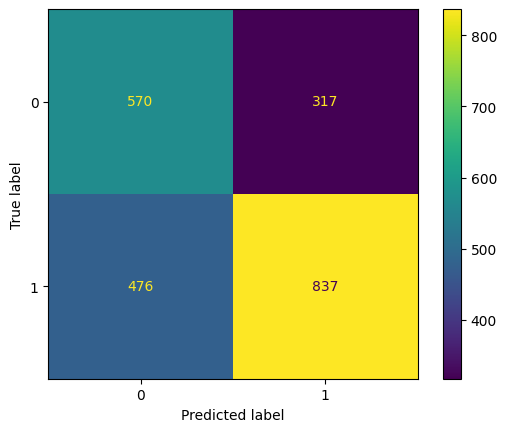

ROC AUC Score: 0.7251223778175233


In [28]:
# Evaluation
y_pred = final_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.show()
print("ROC AUC Score:", roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1]))


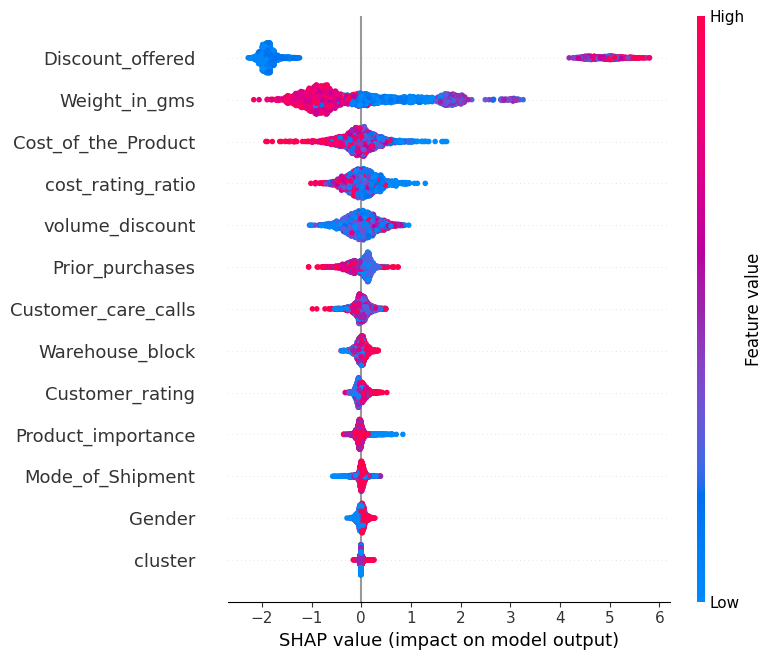

In [29]:
# Explainability
explainer = shap.Explainer(final_model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [33]:
# save model
import joblib
import os
os.makedirs('delivery_api', exist_ok=True)
joblib.dump(final_model, '/content/drive/MyDrive/Delivery_On_Time_Prediction_ML_Project/Delivery_api/delivery_model.pkl')

['/content/drive/MyDrive/Delivery_On_Time_Prediction_ML_Project/Delivery_api/delivery_model.pkl']